In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from Classification.cnn1D_model import VibrationDataset, CNN1D_Wide
from Classification.cnn1D_model import train_and_evaluate, train_and_evaluate_with_kfold
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft, visualize_crp_heatmap, visualize_crp_timefreq
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter
from utils.crp_utils import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/20] - Train Loss: 0.5714, Train Acc: 0.8070 - Val Loss: 0.1440, Val Acc: 0.9458 
Epoch [2/20] - Train Loss: 0.0816, Train Acc: 0.9714 - Val Loss: 0.0506, Val Acc: 0.9876 
Epoch [3/20] - Train Loss: 0.0469, Train Acc: 0.9850 - Val Loss: 0.0522, Val Acc: 0.9840 
Epoch [4/20] - Train Loss: 0.0284, Train Acc: 0.9916 - Val Loss: 0.0284, Val Acc: 0.9911 
Epoch [5/20] - Train Loss: 0.0429, Train Acc: 0.9861 - Val Loss: 0.0292, Val Acc: 0.9929 
Epoch [6/20] - Train Loss: 0.0215, Train Acc: 0.9928 - Val Loss: 0.0657, Val Acc: 0.9769 
Epoch [7/20] - Train Loss: 0.0219, Train Acc: 0.9939 - Val Loss: 0.0250, Val Acc: 0.9920 
Epoch [8/20] - Train Loss: 0.0177, Train Acc: 0.9956 - Val Loss: 0.0380, Val Acc: 0.9867 
Epoch [9/20] - Train Loss: 0.0171, Train Acc: 0.9958 - Val Loss: 0.0183, Val Acc: 0.9929 
Epoch [10/20] - Train Loss: 0.0148, Train Acc: 0.9956 - Val Loss: 0.0159, Val Acc: 0.9956 
Epoch [11/20] - Train Loss: 0.0128, Train Acc: 0.9970 - Val Loss: 0.0136, Val Ac

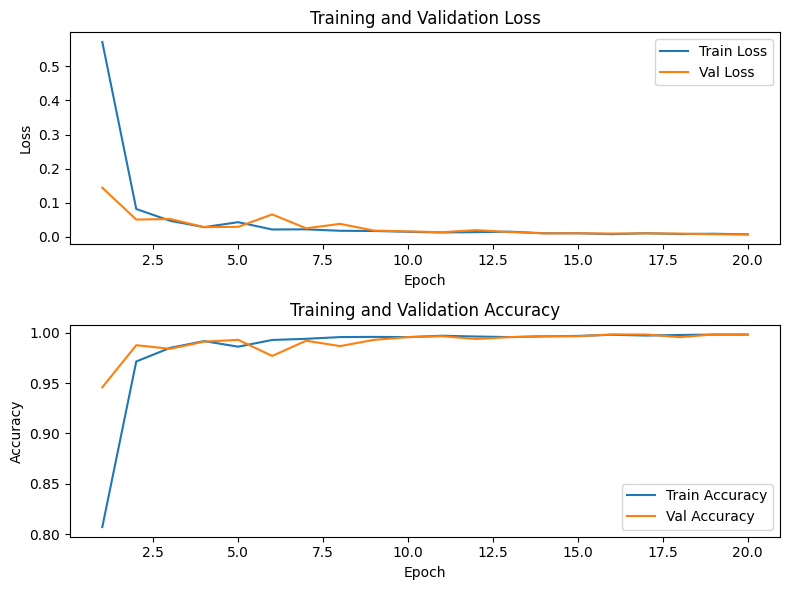

In [16]:
# ------------------------
#  Run Training & Evaluation
# ------------------------
# model = train_and_evaluate(train_loader, val_loader, test_loader)
best_model = train_and_evaluate(train_loader, val_loader, test_loader, EralyStopping=True, Schedule=True)



In [17]:
# Save the trained model
torch.save(best_model.state_dict(), "../cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")
best_model.to(device)
best_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {best_model}")


✅ Model saved to cnn1d_model.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 CNN1D_Wide(
  (conv1): Conv1d(3, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.2, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_feat

### Explain the Model

#### choose a good sample

In [22]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))

random.seed(44)
# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(best_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


Random Index: 104, Predicted_label:0, True_label:0
tensor([[-0.5289, -0.3780, -0.2401,  ...,  0.0158, -0.1304, -0.1163],
        [ 0.4438, -0.3268,  0.1496,  ..., -0.0904,  0.1415, -0.0846],
        [ 0.3682, -0.4331, -0.0903,  ...,  0.1153,  0.1070,  0.0278]],
       device='cuda:0') torch.Size([3, 2000])


#### DFT-LRP implementation

In [23]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Min relevance: 1.0568516728426403e-07, Max relevance: 0.09636055678129196
 Maximum Absolute Attribution in Axis 0: 0.09636055678129196
 Maximum Absolute Attribution in Axis 1: 0.018845196813344955
 Maximum Absolute Attribution in Axis 2: 0.018499165773391724


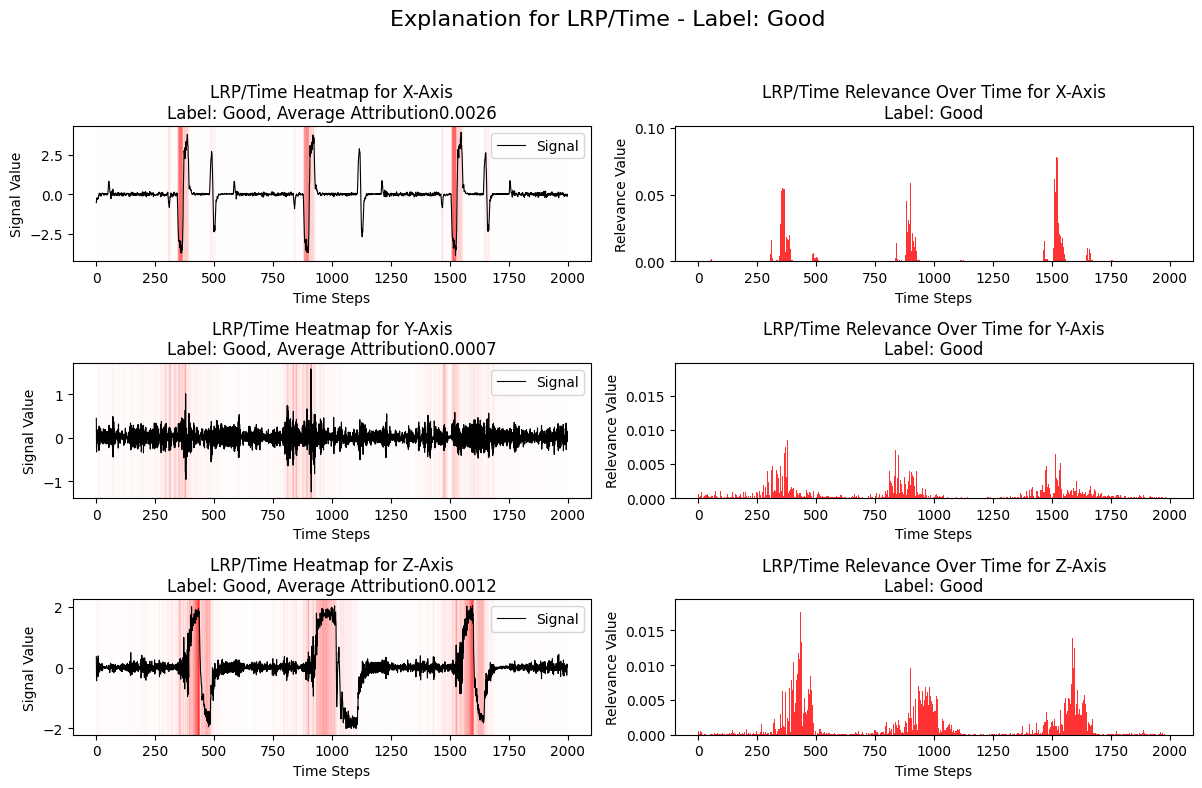

In [24]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [25]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             670                  5.297825   
1  Axis 1             728                  1.422246   
2  Axis 2             704                  2.639187   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.007907             331                 -0.185203   
1                    0.001954             273                 -0.095504   
2                    0.003749             297                 -0.233108   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000560                     5.112622   
1                   -0.000350                     1.326742   
2                   -0.000785                     2.406078   

   Average Relevance (Pos + Neg)  
0                       0.005108  
1                       0.001325  
2                       0.002404  


In [26]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            2000                  5.102555   
1  Axis 1            2000                  1.326457   
2  Axis 2            2000                  2.472486   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002551               0                       0.0   
1                    0.000663               0                       0.0   
2                    0.001236               0                       0.0   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                           0                     5.102555   
1                           0                     1.326457   
2                           0                     2.472486   

   Average Relevance (Pos + Neg)  
0                       0.002551  
1                       0.000663  
2                       0.001236  


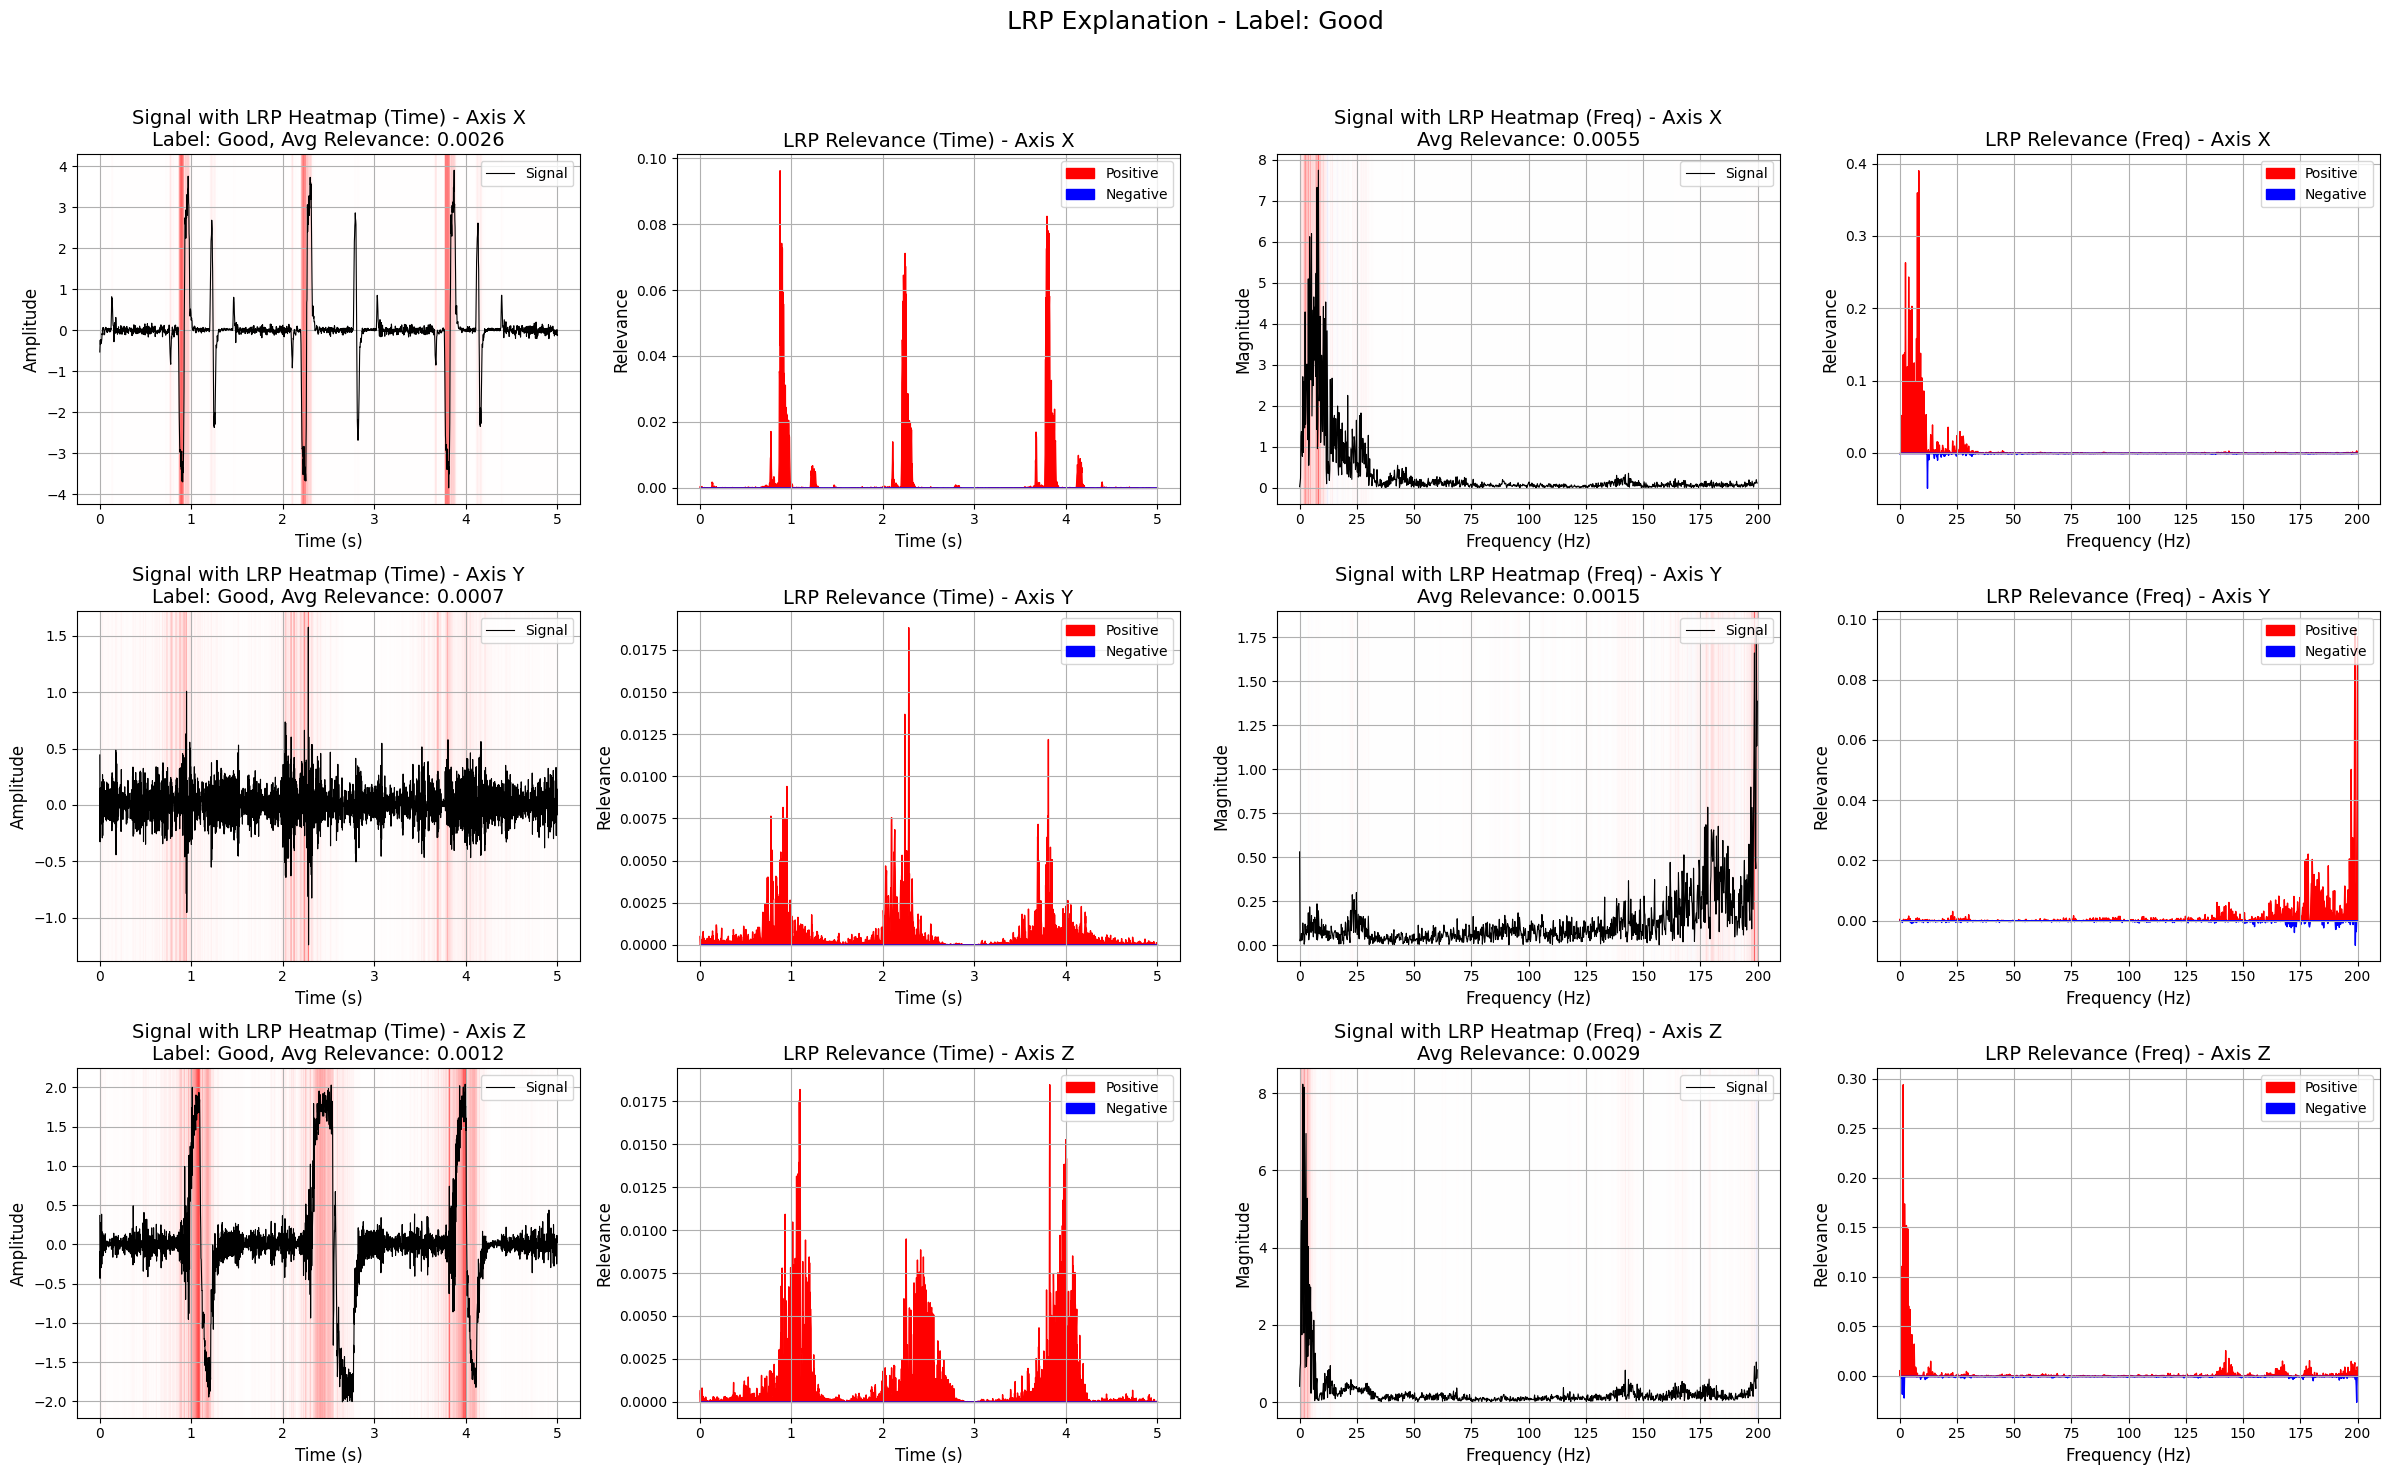

In [27]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [13]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

In [80]:
get_layer_channels(best_model, layer_name = 'conv4')

128

In [ ]:
# feature_layer = layer_names[len(layer_names)//2]  # Pick a middle layer
# Get the number of channels in that layer
# num_channels = get_layer_channels(model, feature_layer)
# conditions = [{feature_layer: list(range(num_channels)), "y": [target_label]}]

In [81]:
heatmap, attr = compute_crp_relevance(best_model, sample)

['conv1', 'conv2', 'conv3', 'conv4', 'fc1', 'fc2']
conv4
128
Most relevant channels in conv4: [[ 39  53 120  44  57   8 106   2  35  67  13 125  97  37 122  82  51  77
   74  31  32   4  92  49 113  66  76  70   5   9  75  95  10 119  71  81
   36   6  65  19  93  17  99  59  68 123  38  34  90 103  60  25  78  12
   15  27  96 114   3  29 116 115  58 121  11  87  54  46 110  69  56  20
  127   1  40 109  18  64 107  41  47  98  88  84  63  22  50   7  89  85
  112 100 104  83 105  14 101  55 117  91  42  62  28  86 126  48  94  24
   79  72 118  33 111  80 108  43  23  73 124  16 102  45  21   0  26  61
   30  52]]


In [82]:
print(heatmap, heatmap.shape)

[5.6723005e-04 6.6135603e-04 6.8655919e-04 ... 7.6309683e-05 7.1603725e-05
 6.3426487e-05] (2000,)


[DEBUG] signal shape: (3, 2000)
[DEBUG] crp_heatmap shape: (3, 2000)
[DEBUG] crp_heatmap min: 4.3034157e-05 max: 0.050723758 mean: 0.004474116


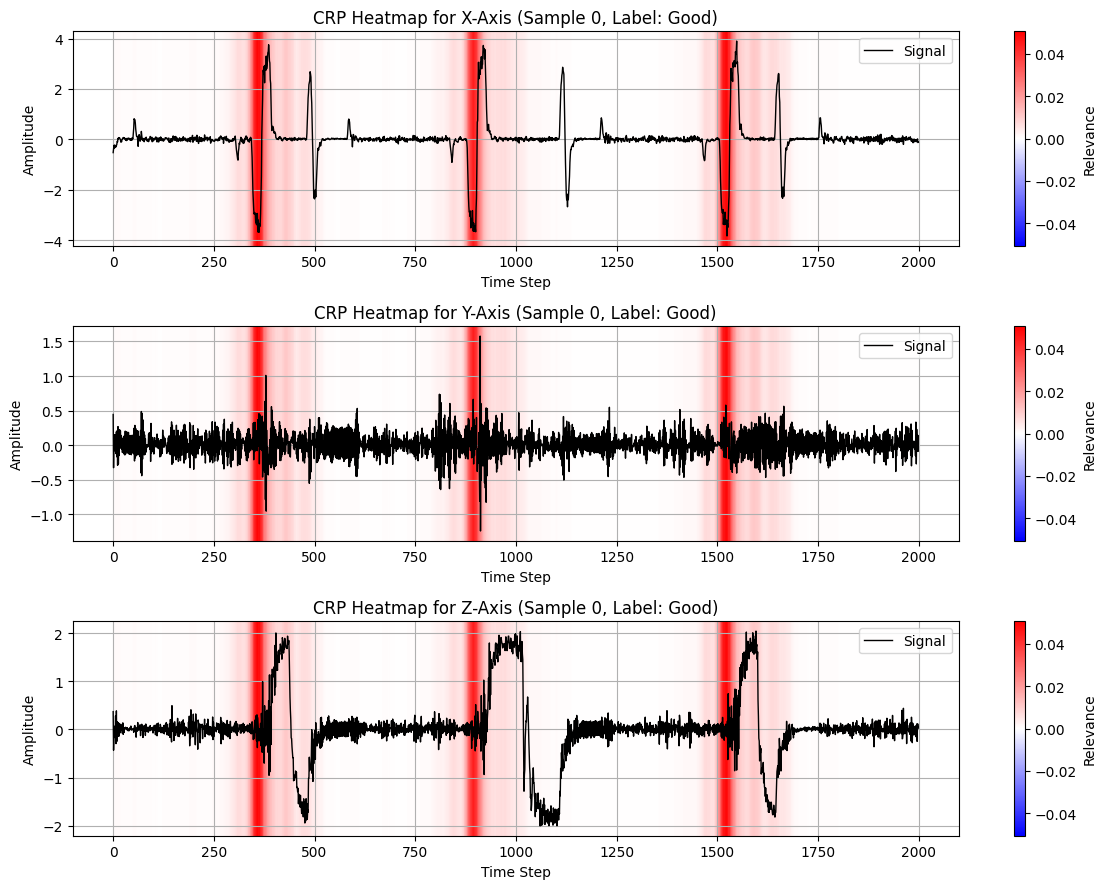

In [83]:
visualize_crp_heatmap(sample, heatmap, label)


#### FFT-LRP implementation

In [33]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=best_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-0.0377,  0.0037,  0.0118,  ...,  0.0078, -0.0007, -0.0188]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.0007,  0.0054,  ..., -0.0008, -0.0038, -0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

E:\Thesis\Datasets\CNC\utils\fft_lrp.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:308.)
  arr = torch.from_numpy(arr).to(dtype=self.dtype)


In [34]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             670        2.136414+0.000000j   
1  Axis 1             728        2.674357+0.000000j   
2  Axis 2             705        2.586260+0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.003189+0.000000j             331       -0.516111+0.000000j   
1          0.003674+0.000000j             273       -0.485872+0.000000j   
2          0.003668+0.000000j             296       -0.560543+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.001559+0.000000j           1.620303+0.000000j   
1         -0.001780+0.000000j           2.188484+0.000000j   
2         -0.001894+0.000000j           2.025717+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.001619+0.000000j  
1             0.002186+0.000000j  
2             0.002024+0.000000j  


In [35]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           15347       9.110441+ 0.000000j   
1  Axis 1           15815      10.800711+ 0.000000j   
2  Axis 2           15827      10.777470+ 0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.000594+0.000000j            4673       -1.447991+0.000000j   
1          0.000683+0.000000j            4205       -1.101195+0.000000j   
2          0.000681+0.000000j            4193       -1.497735+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.000310+0.000000j           7.662450+0.000000j   
1         -0.000262+0.000000j           9.699516+0.000000j   
2         -0.000357+0.000000j           9.279735+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.000383+0.000000j  
1             0.000484+0.000000j  
2             0.000464+0.000000j  


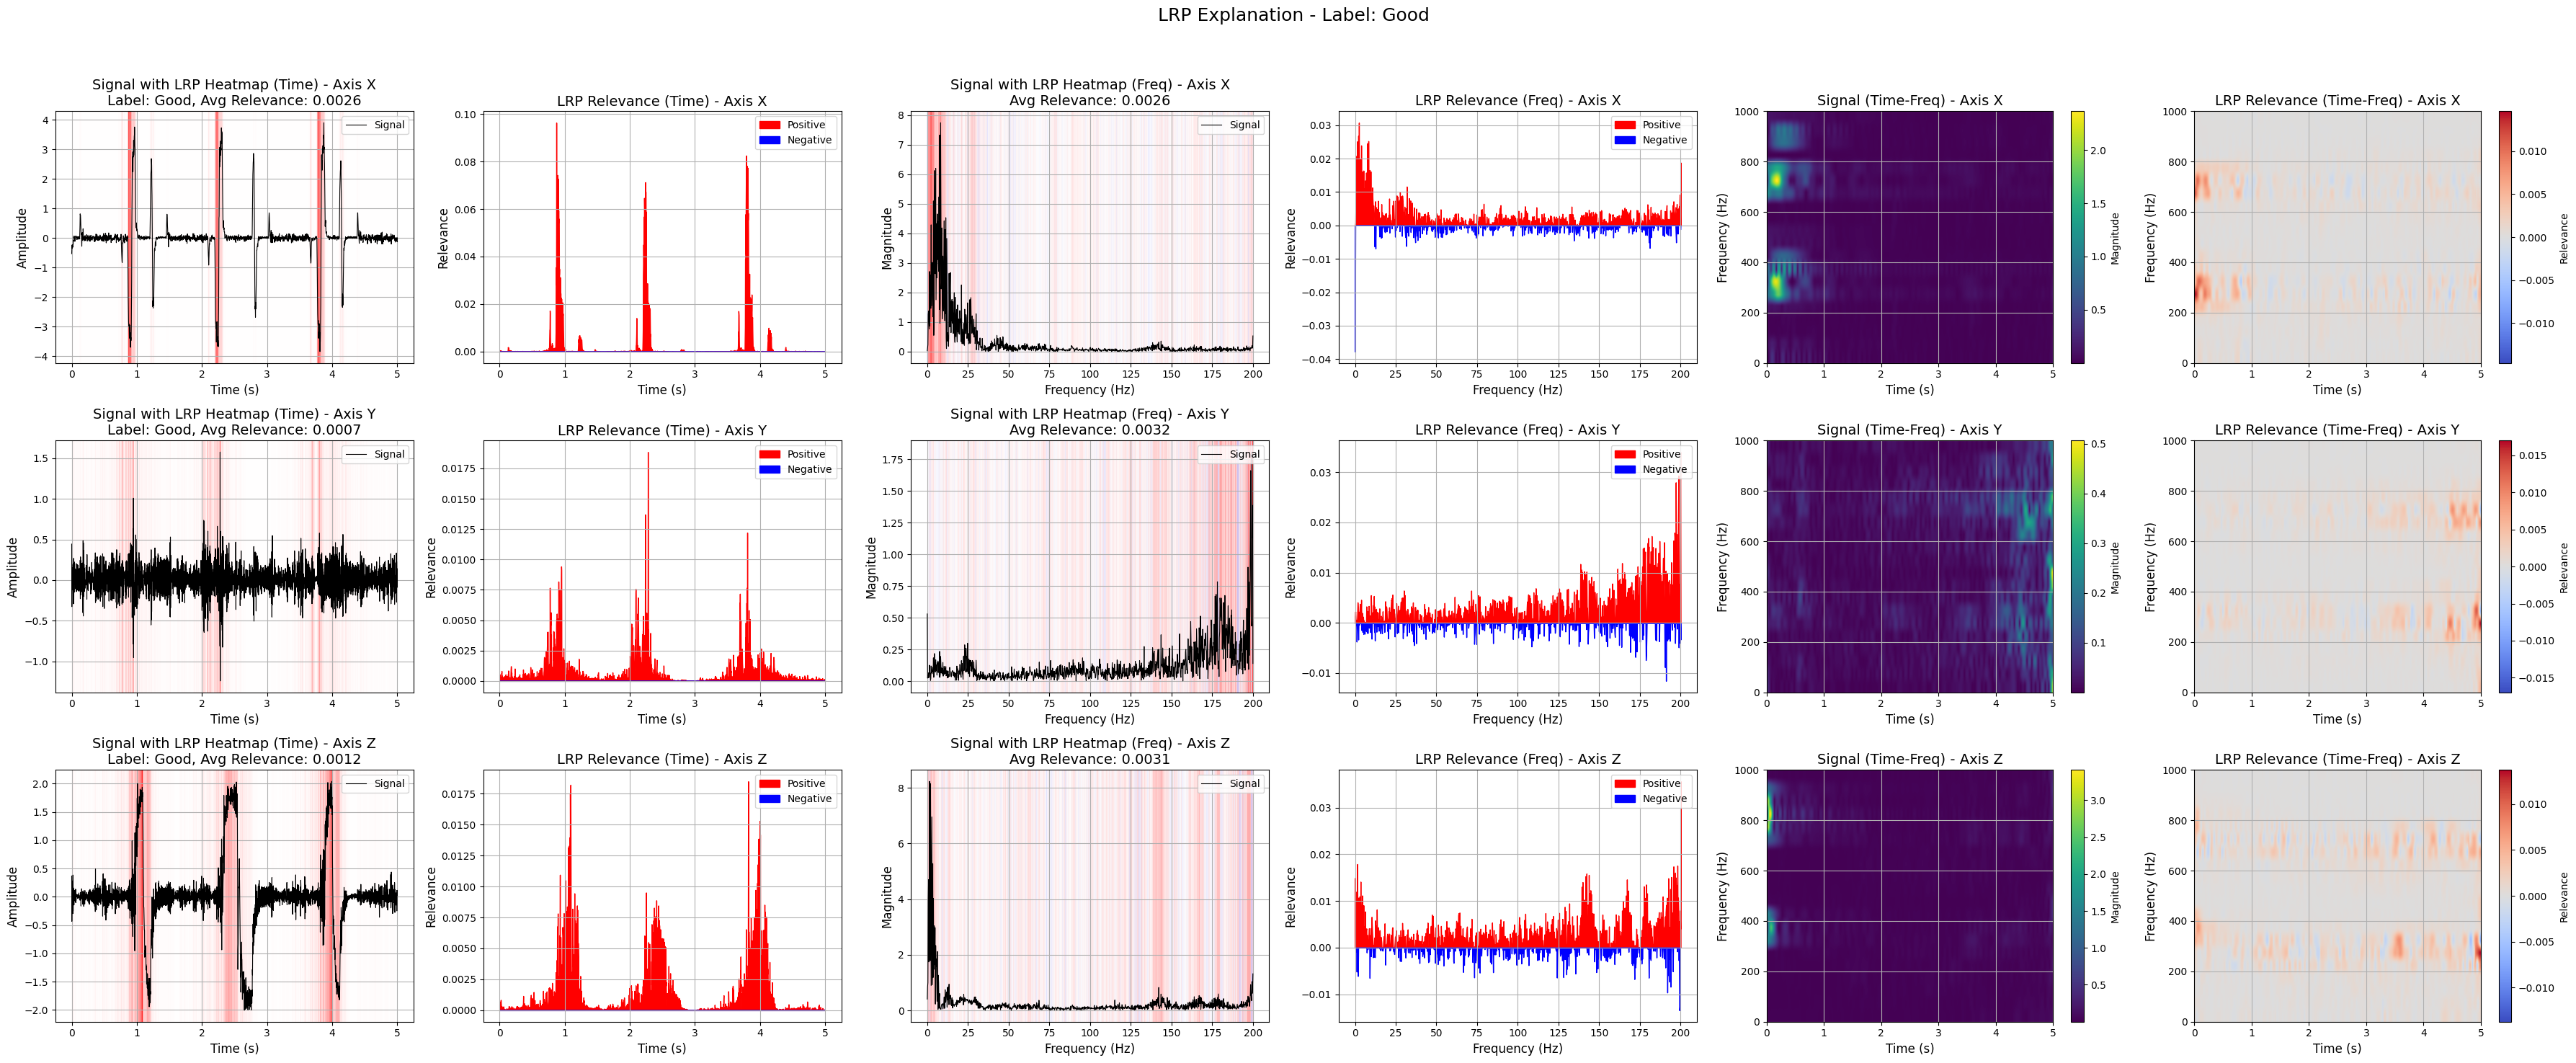

In [36]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

Min relevance: -1.35333251953125, Max relevance: 3.914283514022827
 Maximum Absolute Attribution in Axis 0: 3.914283514022827
 Maximum Absolute Attribution in Axis 1: 0.3308376669883728
 Maximum Absolute Attribution in Axis 2: 1.35333251953125


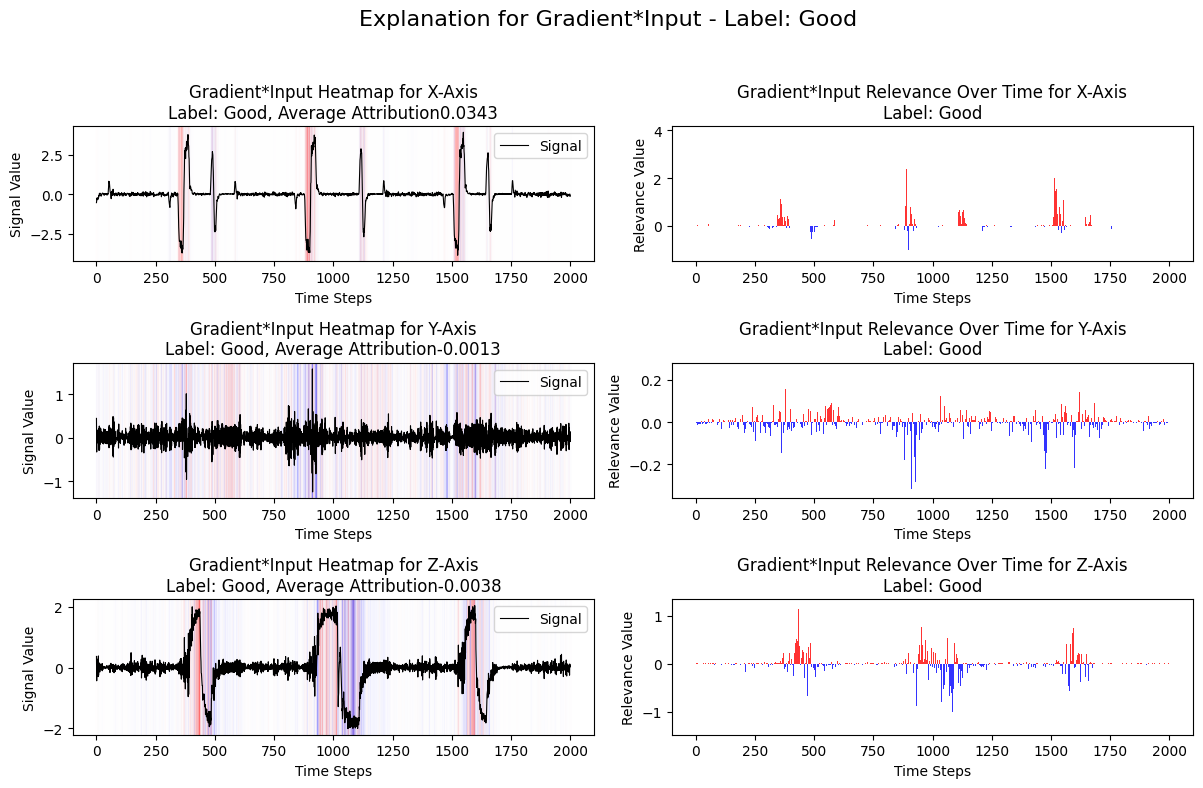

In [37]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(best_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [38]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             983                108.758514   
1  Axis 1             997                 20.952246   
2  Axis 2             874                 63.431702   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.110639            1017                -40.141548   
1                    0.021015            1003                -23.627834   
2                    0.072576            1126                -71.085373   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.039471                    68.616966   
1                   -0.023557                    -2.675589   
2                   -0.063131                    -7.653671   

   Average Relevance (Pos + Neg)  
0                       0.034308  
1                      -0.001338  
2                      -0.003827  


Min relevance: -0.20150096714496613, Max relevance: 0.07406742125749588
 Maximum Absolute Attribution in Axis 0: 0.20150096714496613
 Maximum Absolute Attribution in Axis 1: 0.031789179891347885
 Maximum Absolute Attribution in Axis 2: 0.0804942324757576


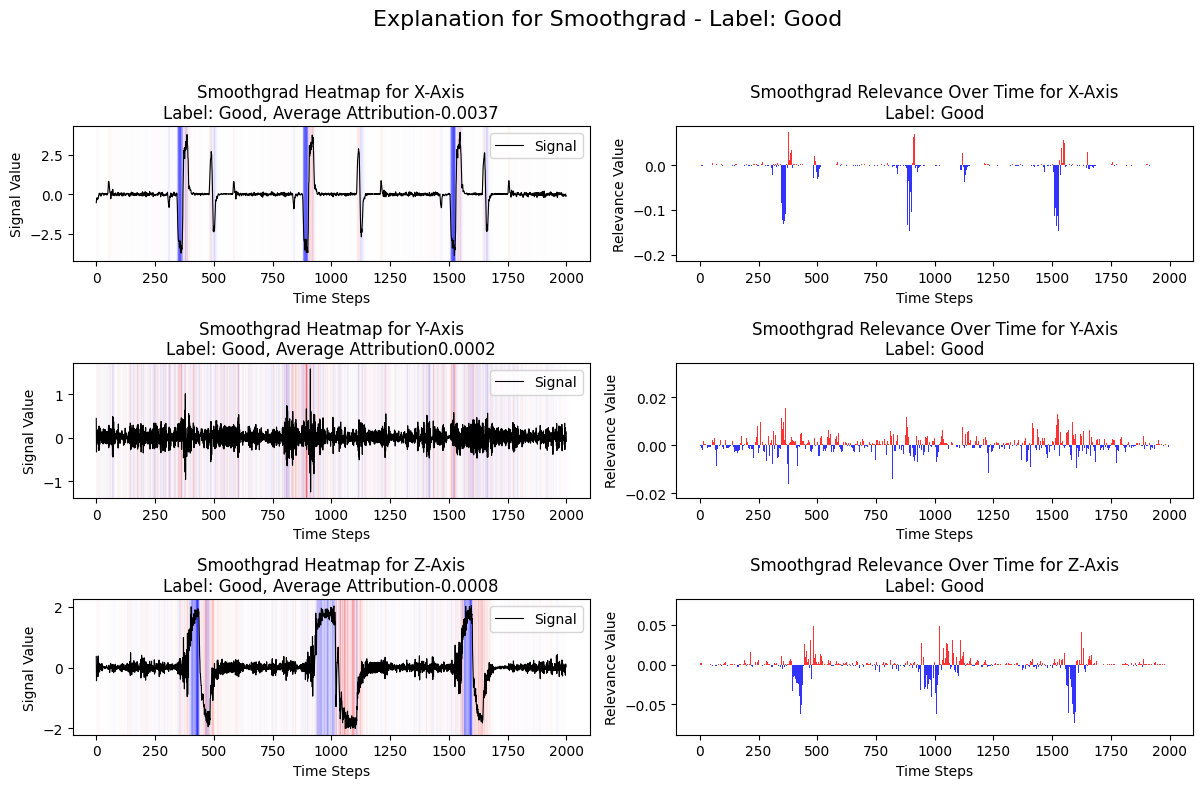

In [39]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(best_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.09057044982910156, Max relevance: 0.3623228073120117
 Maximum Absolute Attribution in Axis 0: 0.3623228073120117
 Maximum Absolute Attribution in Axis 1: 0.031106948852539062
 Maximum Absolute Attribution in Axis 2: 0.13523292541503906


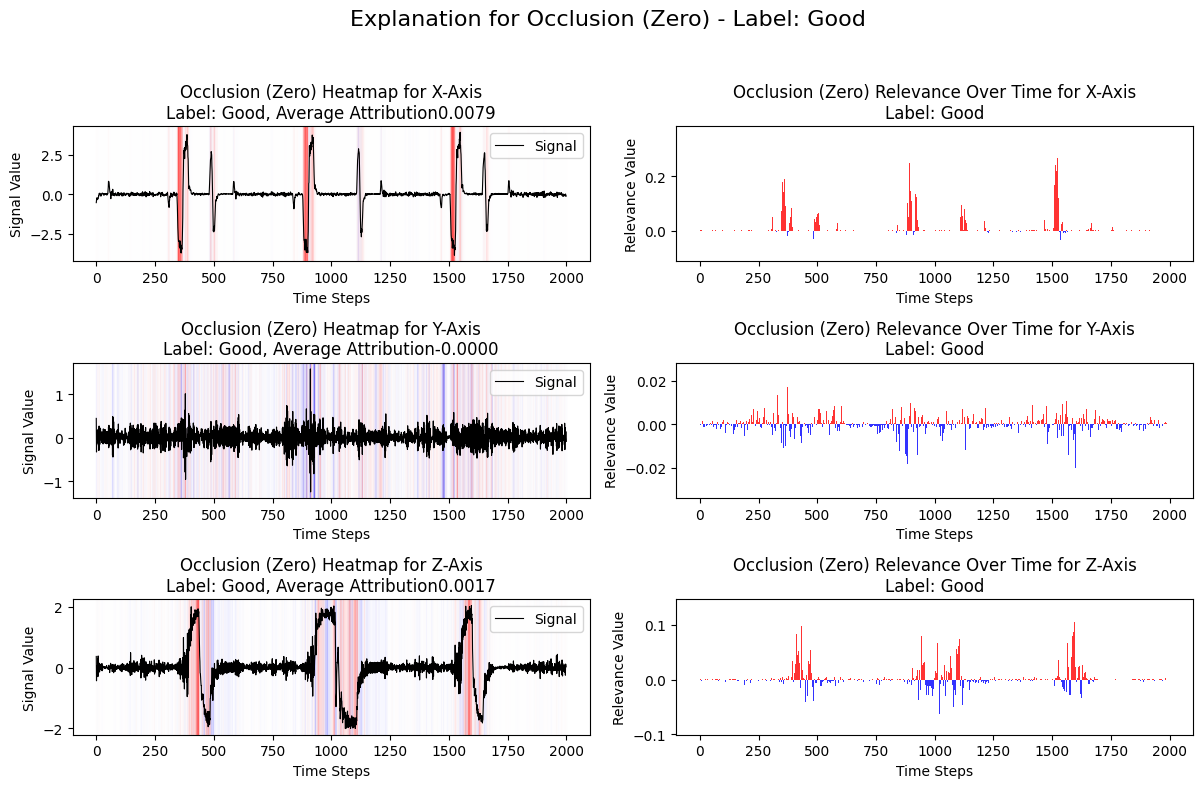

In [40]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.5465364456176758, Max relevance: 1.8655824661254883
 Maximum Absolute Attribution in Axis 0: 1.8655824661254883
 Maximum Absolute Attribution in Axis 1: 1.8655824661254883
 Maximum Absolute Attribution in Axis 2: 1.8655824661254883


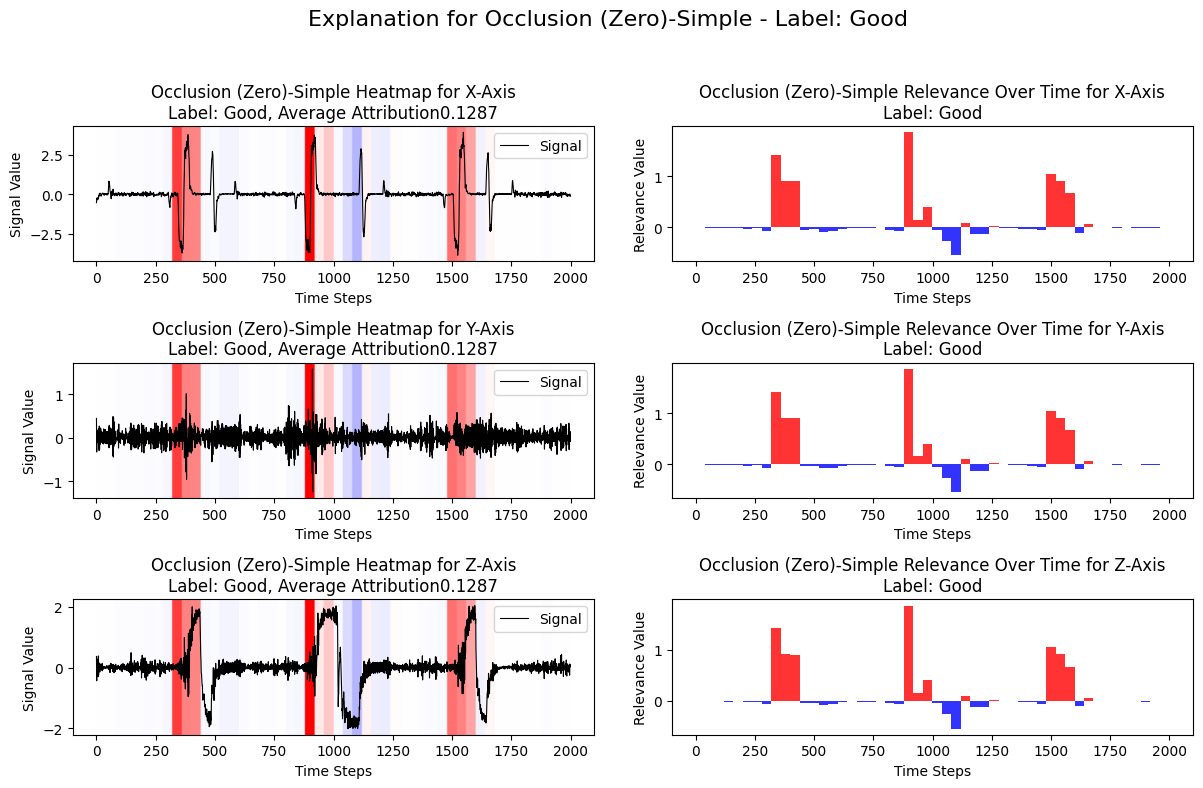

In [41]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -1.3979511260986328, Max relevance: 2.3516550064086914
 Maximum Absolute Attribution in Axis 0: 2.3516550064086914
 Maximum Absolute Attribution in Axis 1: 2.3516550064086914
 Maximum Absolute Attribution in Axis 2: 2.3516550064086914


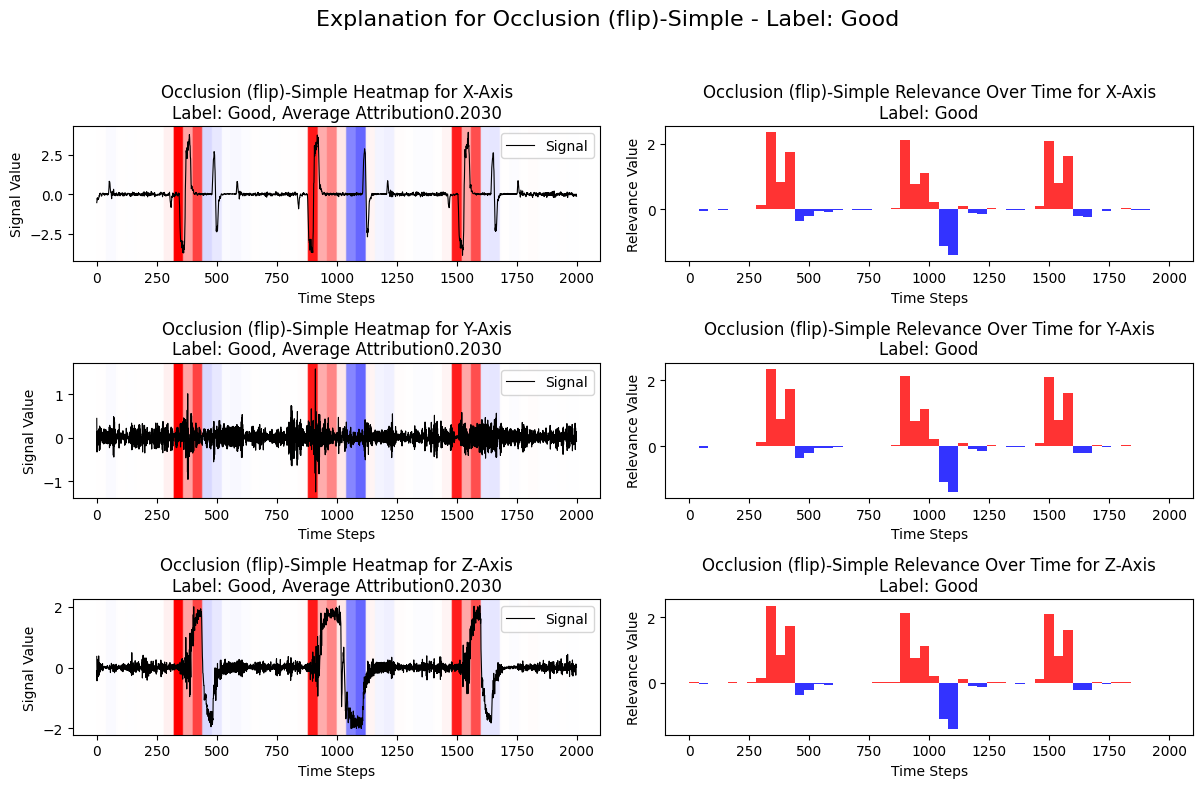

In [42]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.09466075897216797, Max relevance: 0.46750450134277344
 Maximum Absolute Attribution in Axis 0: 0.46750450134277344
 Maximum Absolute Attribution in Axis 1: 0.10444259643554688
 Maximum Absolute Attribution in Axis 2: 0.17434120178222656


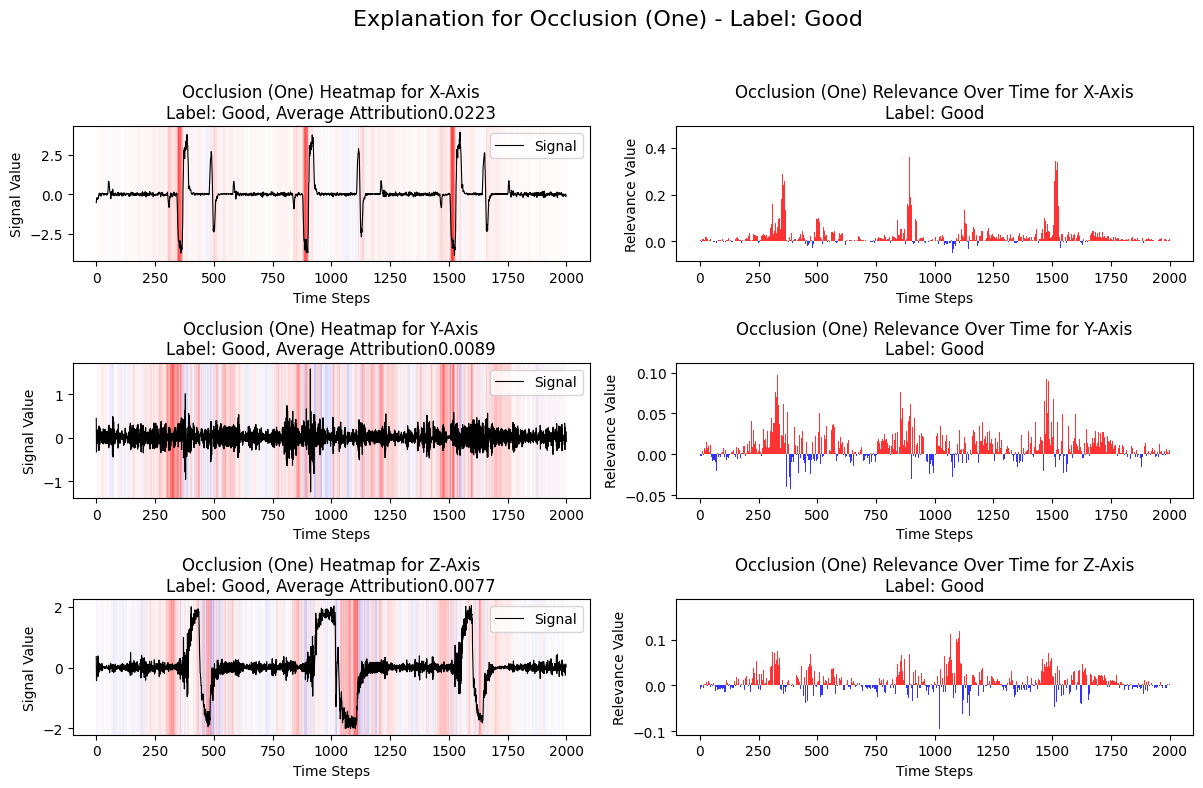

In [43]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.10582637786865234, Max relevance: 0.2548255920410156
 Maximum Absolute Attribution in Axis 0: 0.2548255920410156
 Maximum Absolute Attribution in Axis 1: 0.09149360656738281
 Maximum Absolute Attribution in Axis 2: 0.24367046356201172


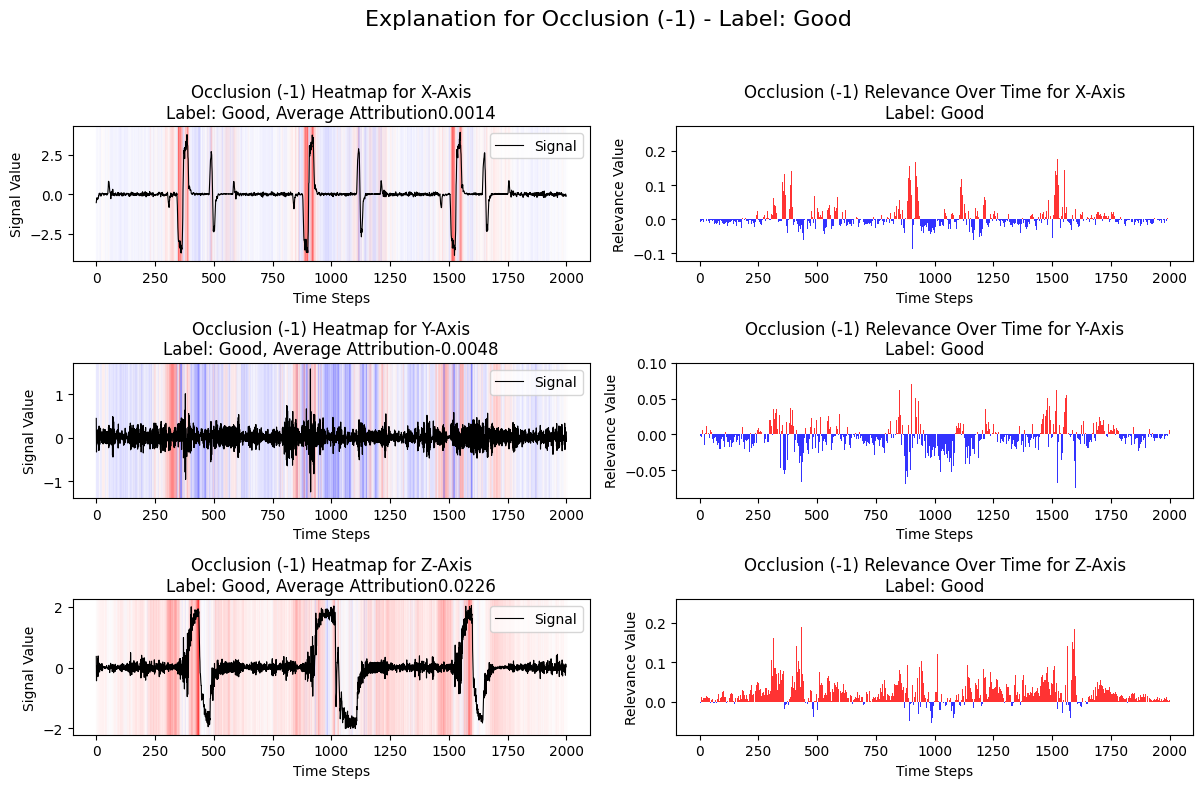

In [44]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.11392021179199219, Max relevance: 0.6828813552856445
 Maximum Absolute Attribution in Axis 0: 0.6828813552856445
 Maximum Absolute Attribution in Axis 1: 0.05151939392089844
 Maximum Absolute Attribution in Axis 2: 0.33466148376464844


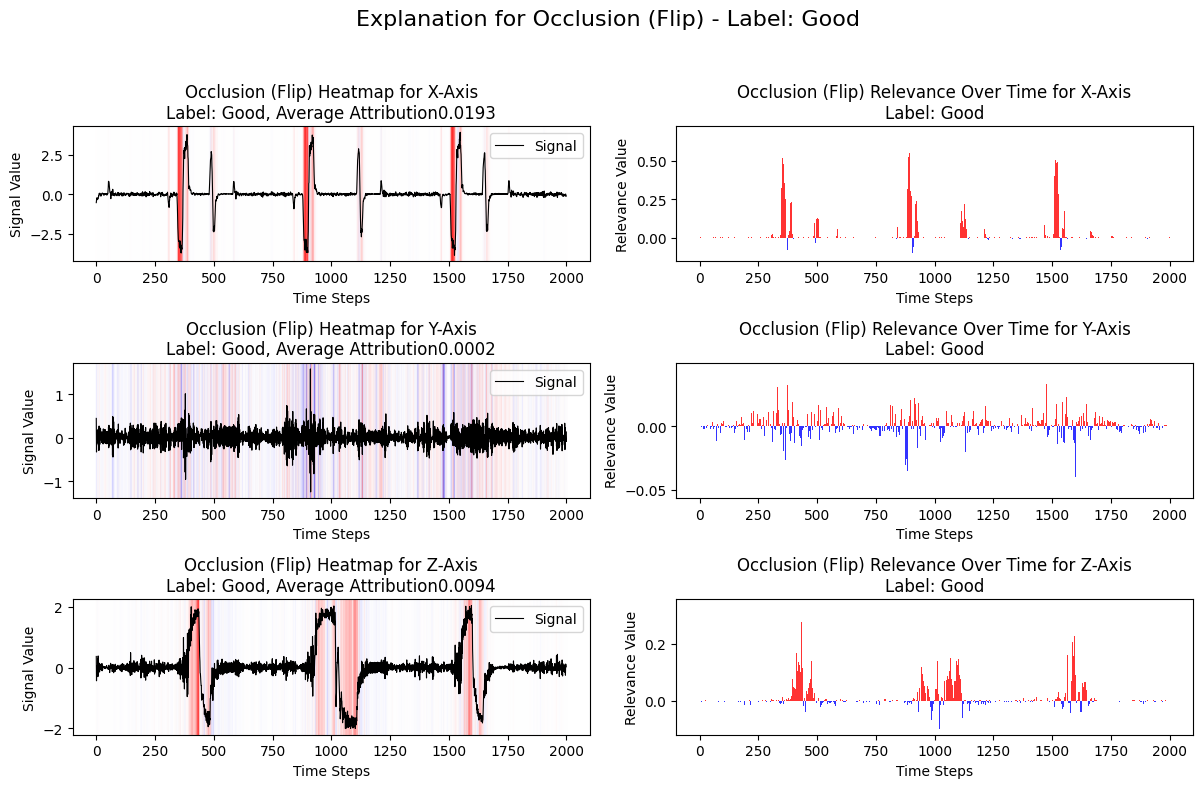

In [45]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [64]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

random.seed(43)
# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(best_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 9, Predicted_label:1, True_label:1
tensor([[ 0.0169, -0.0078, -0.0396,  ...,  0.0457,  0.0410, -0.0431],
        [ 0.6362,  0.1942,  0.8243,  ...,  0.0895, -0.5042,  0.4611],
        [ 0.3551, -0.7743,  0.0925,  ...,  0.3303, -0.6211, -0.0097]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 104 Label: Bad


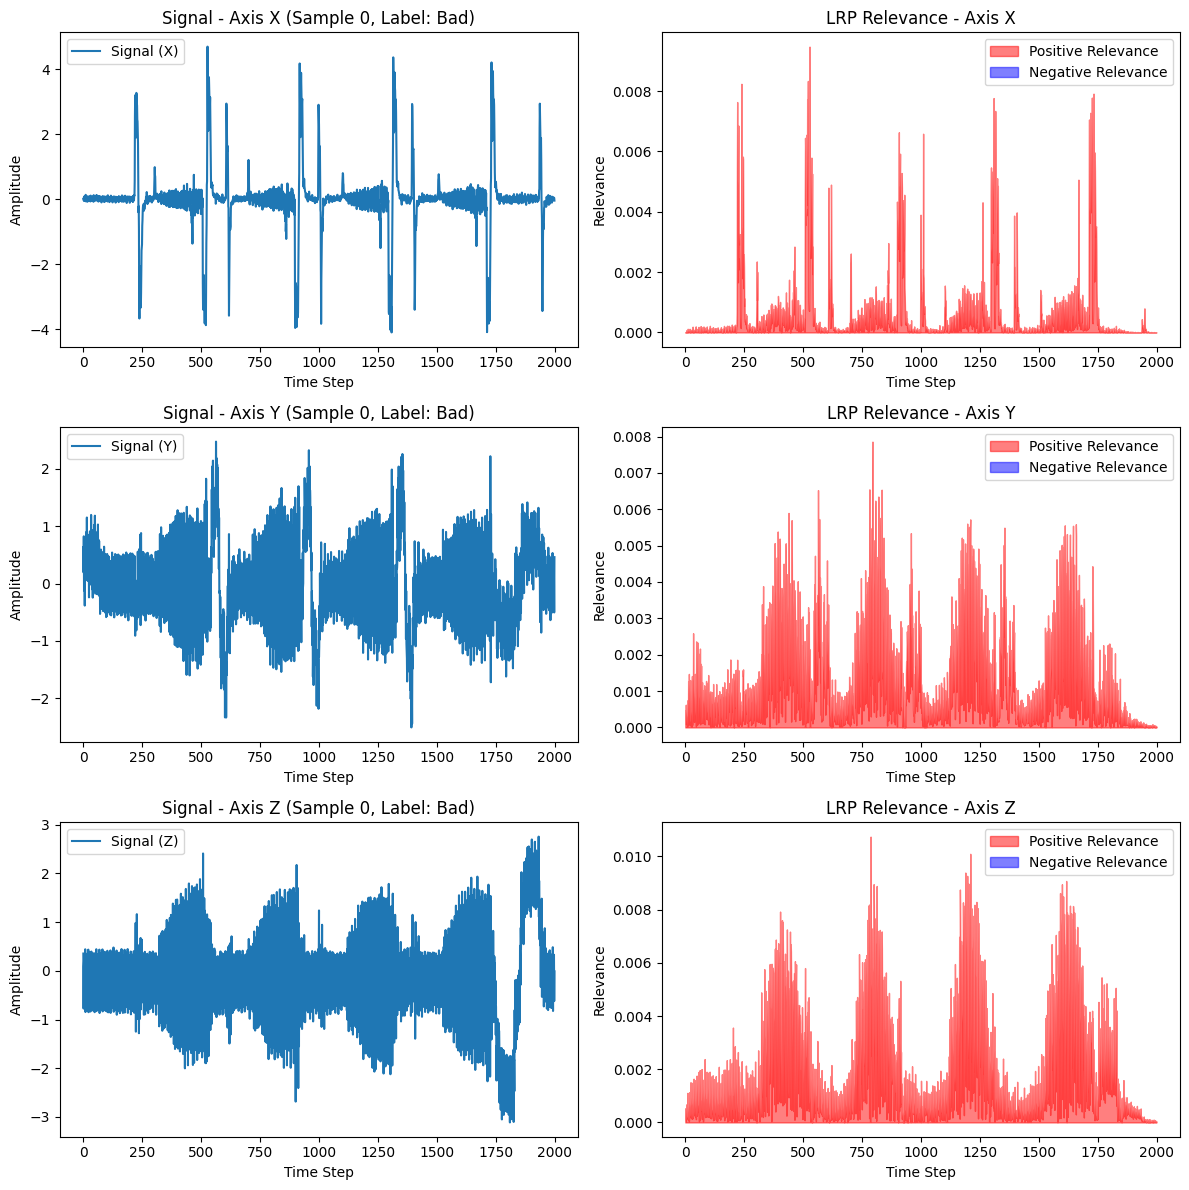

In [65]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=best_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: 1.5497572292133555e-07, Max relevance: 0.010743856430053711
 Maximum Absolute Attribution in Axis 0: 0.00947099830955267
 Maximum Absolute Attribution in Axis 1: 0.007859441451728344
 Maximum Absolute Attribution in Axis 2: 0.010743856430053711


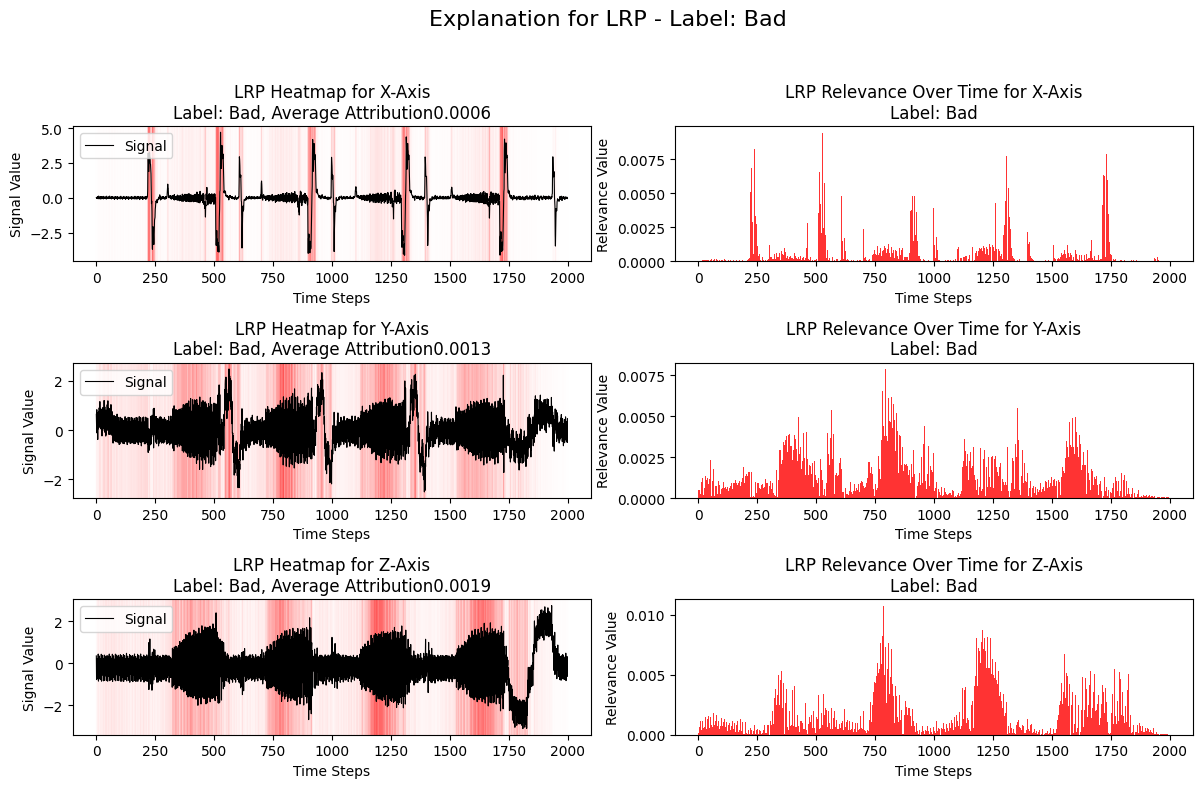

In [66]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


Min relevance: -0.8120217323303223, Max relevance: 0.6202777624130249
 Maximum Absolute Attribution in Axis 0: 0.8120217323303223
 Maximum Absolute Attribution in Axis 1: 0.4031345248222351
 Maximum Absolute Attribution in Axis 2: 0.6202777624130249


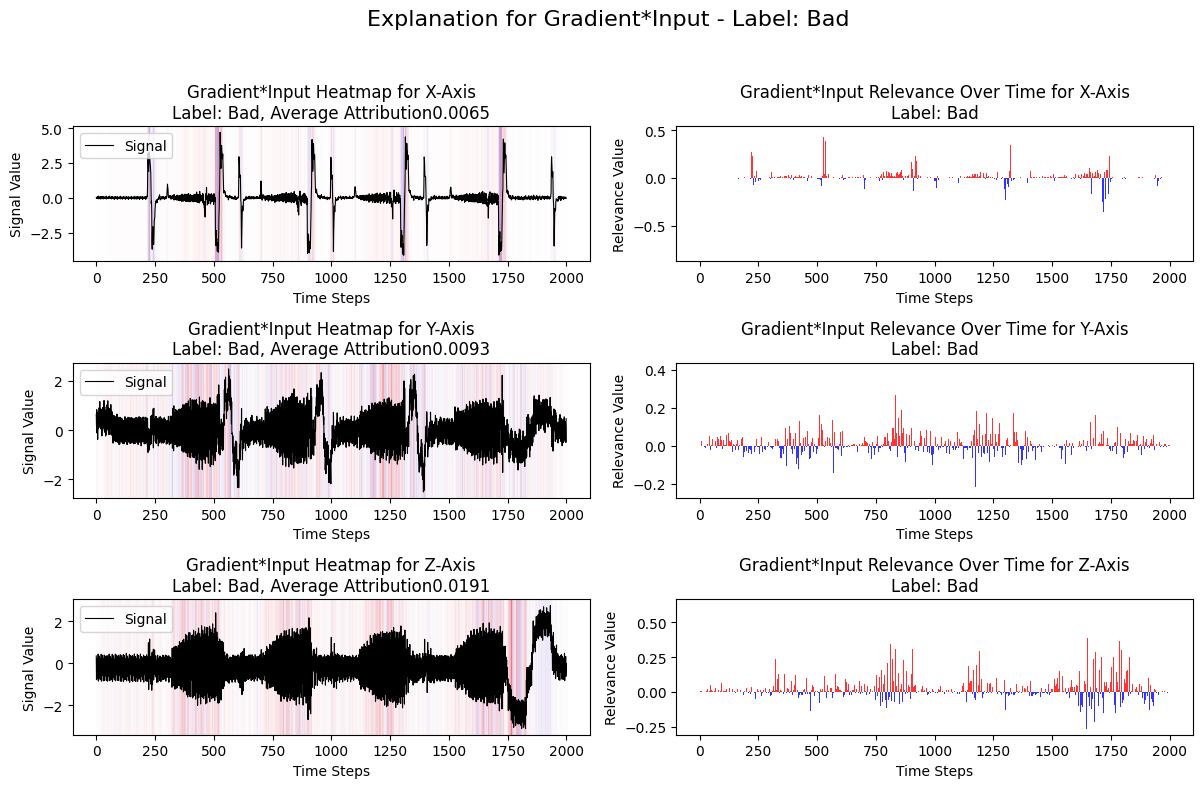

In [67]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [68]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1333                 31.500731   
1  Axis 1            1076                 42.396370   
2  Axis 2            1162                 64.609360   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.023631             667                -18.599386   
1                    0.039402             924                -23.750660   
2                    0.055602             838                -26.382942   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.027885                    12.901344   
1                   -0.025704                    18.645710   
2                   -0.031483                    38.226418   

   Average Relevance (Pos + Neg)  
0                       0.006451  
1                       0.009323  
2                       0.019113  


Min relevance: -0.5698338150978088, Max relevance: 0.4798022210597992
 Maximum Absolute Attribution in Axis 0: 0.5698338150978088
 Maximum Absolute Attribution in Axis 1: 0.1769457310438156
 Maximum Absolute Attribution in Axis 2: 0.3071255087852478


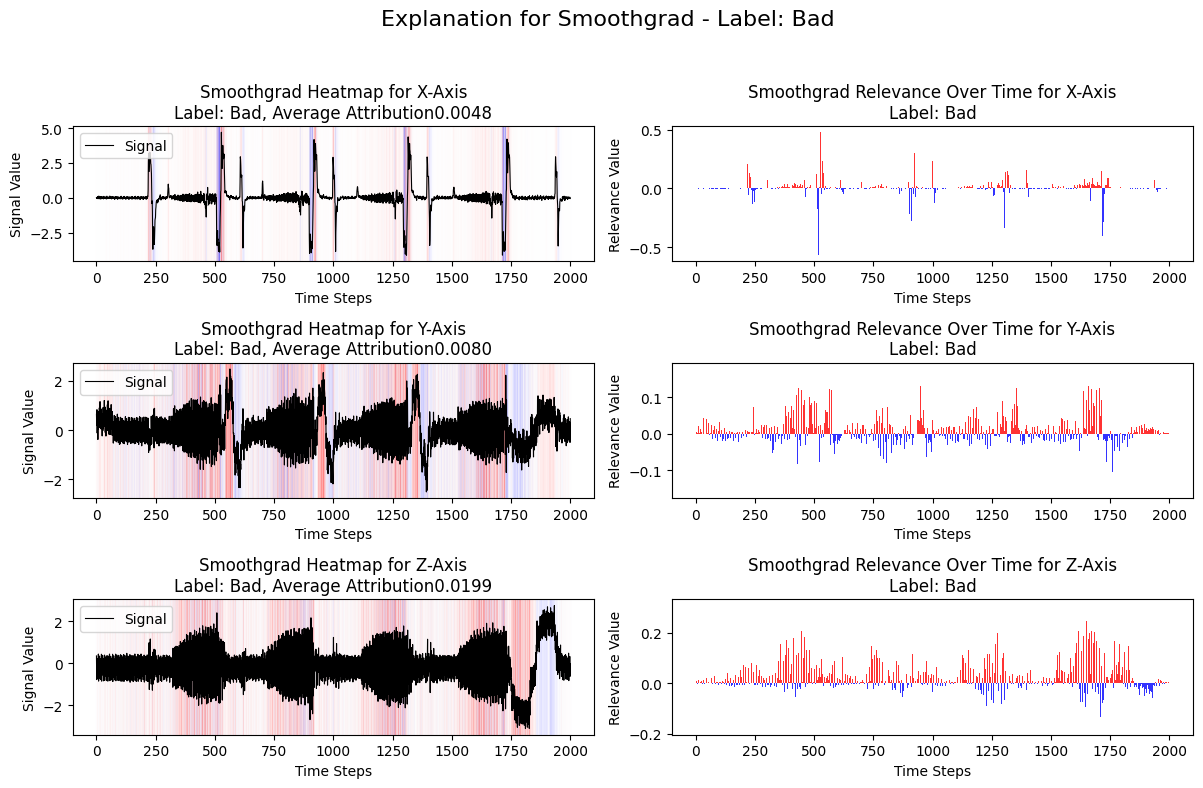

In [69]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [70]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1305                 24.141747   
1  Axis 1            1083                 30.704128   
2  Axis 2            1141                 54.116913   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.018499             695                -14.612433   
1                    0.028351             917                -14.744444   
2                    0.047429             859                -14.376425   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.021025                     9.529313   
1                   -0.016079                    15.959684   
2                   -0.016736                    39.740486   

   Average Relevance (Pos + Neg)  
0                       0.004765  
1                       0.007980  
2                       0.019870  


Min relevance: -0.10131168365478516, Max relevance: 0.05633878707885742
 Maximum Absolute Attribution in Axis 0: 0.10131168365478516
 Maximum Absolute Attribution in Axis 1: 0.03827095031738281
 Maximum Absolute Attribution in Axis 2: 0.044026851654052734


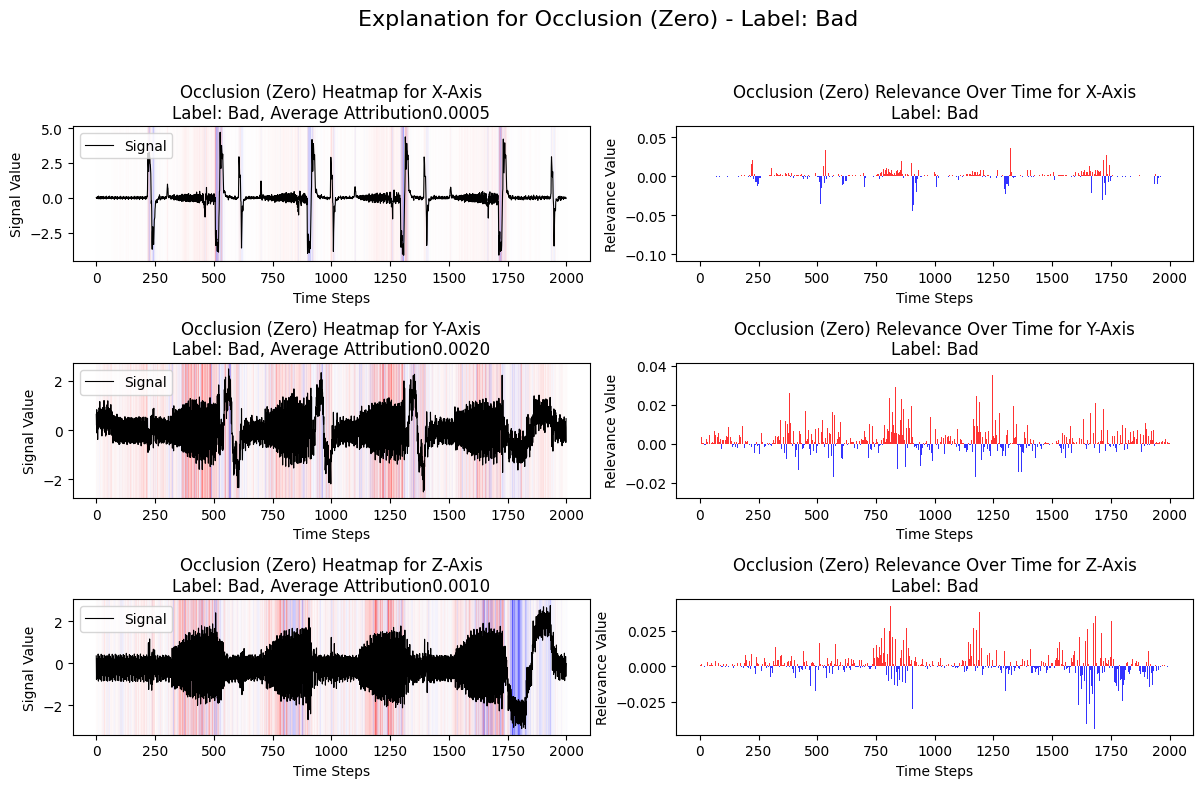

In [71]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.1255497932434082, Max relevance: 0.07353591918945312
 Maximum Absolute Attribution in Axis 0: 0.1255497932434082
 Maximum Absolute Attribution in Axis 1: 0.05570030212402344
 Maximum Absolute Attribution in Axis 2: 0.07510948181152344


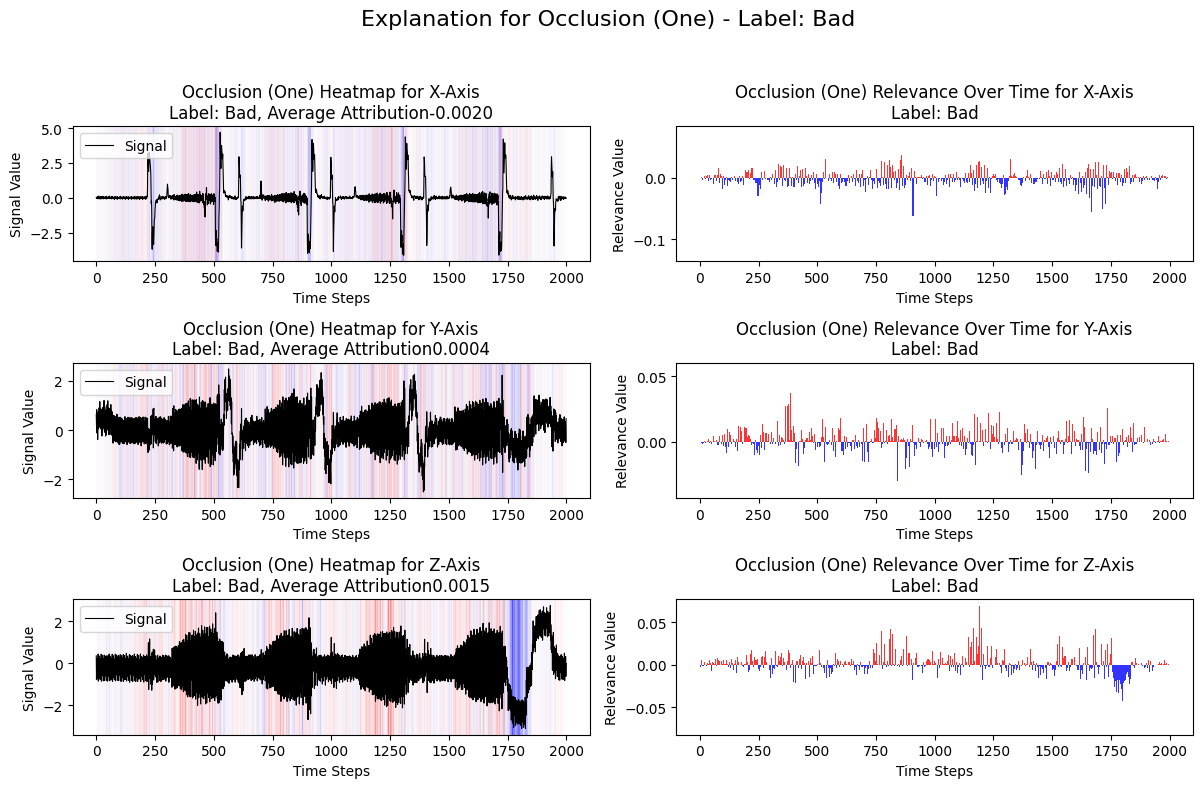

In [72]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.07411766052246094, Max relevance: 0.07502126693725586
 Maximum Absolute Attribution in Axis 0: 0.07411766052246094
 Maximum Absolute Attribution in Axis 1: 0.07502126693725586
 Maximum Absolute Attribution in Axis 2: 0.06743717193603516


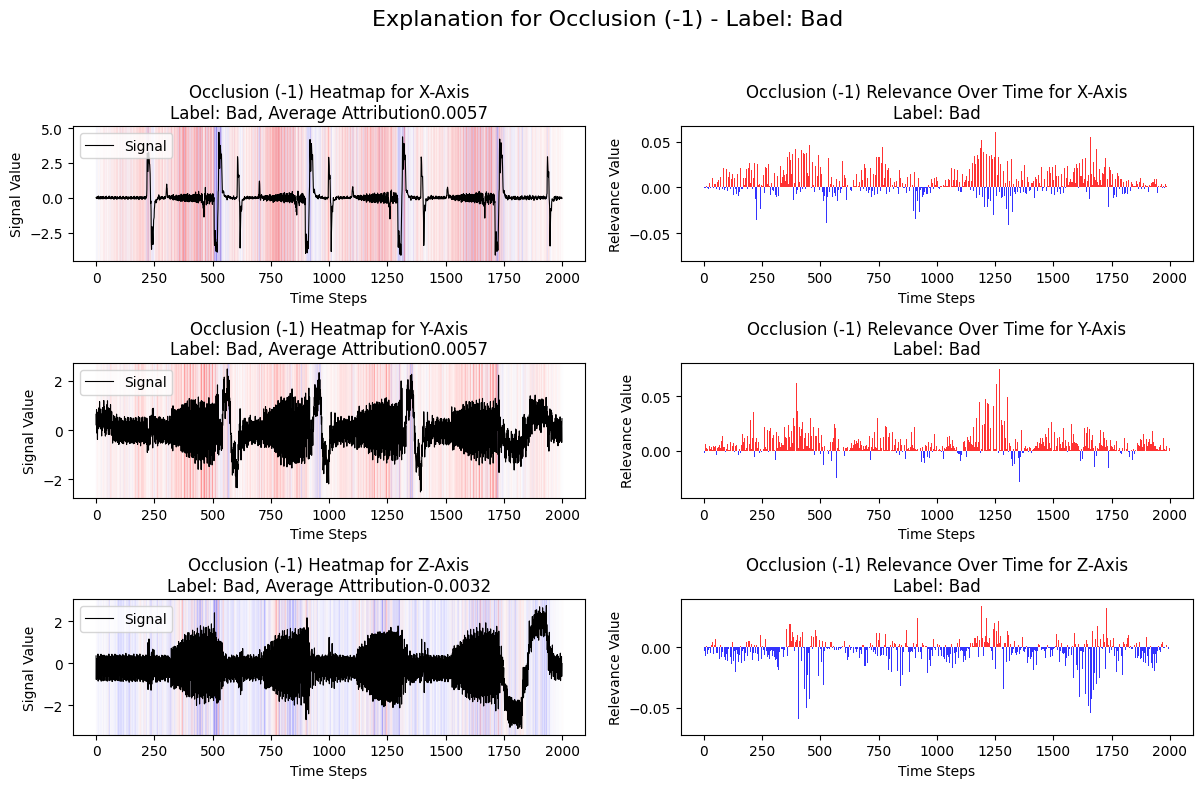

In [73]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.18298864364624023, Max relevance: 0.08740520477294922
 Maximum Absolute Attribution in Axis 0: 0.18298864364624023
 Maximum Absolute Attribution in Axis 1: 0.07622575759887695
 Maximum Absolute Attribution in Axis 2: 0.12840747833251953


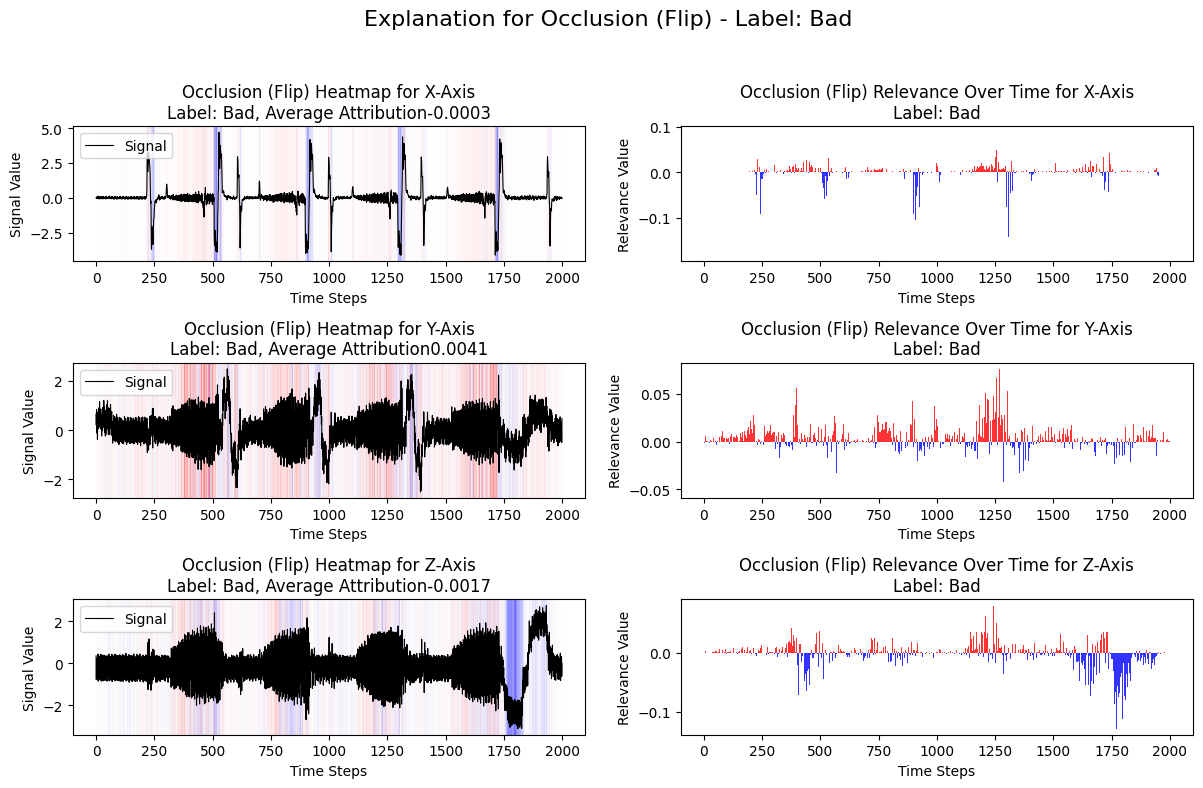

In [74]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [75]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1328                  6.165463   
1  Axis 1            1275                 12.093778   
2  Axis 2             984                  8.402012   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.004643             671                 -6.687934   
1                    0.009485             725                 -3.833408   
2                    0.008539            1016                -11.828346   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.009967                    -0.522471   
1                   -0.005287                     8.260369   
2                   -0.011642                    -3.426334   

   Average Relevance (Pos + Neg)  
0                      -0.000261  
1                       0.004130  
2                      -0.001713  


In [76]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


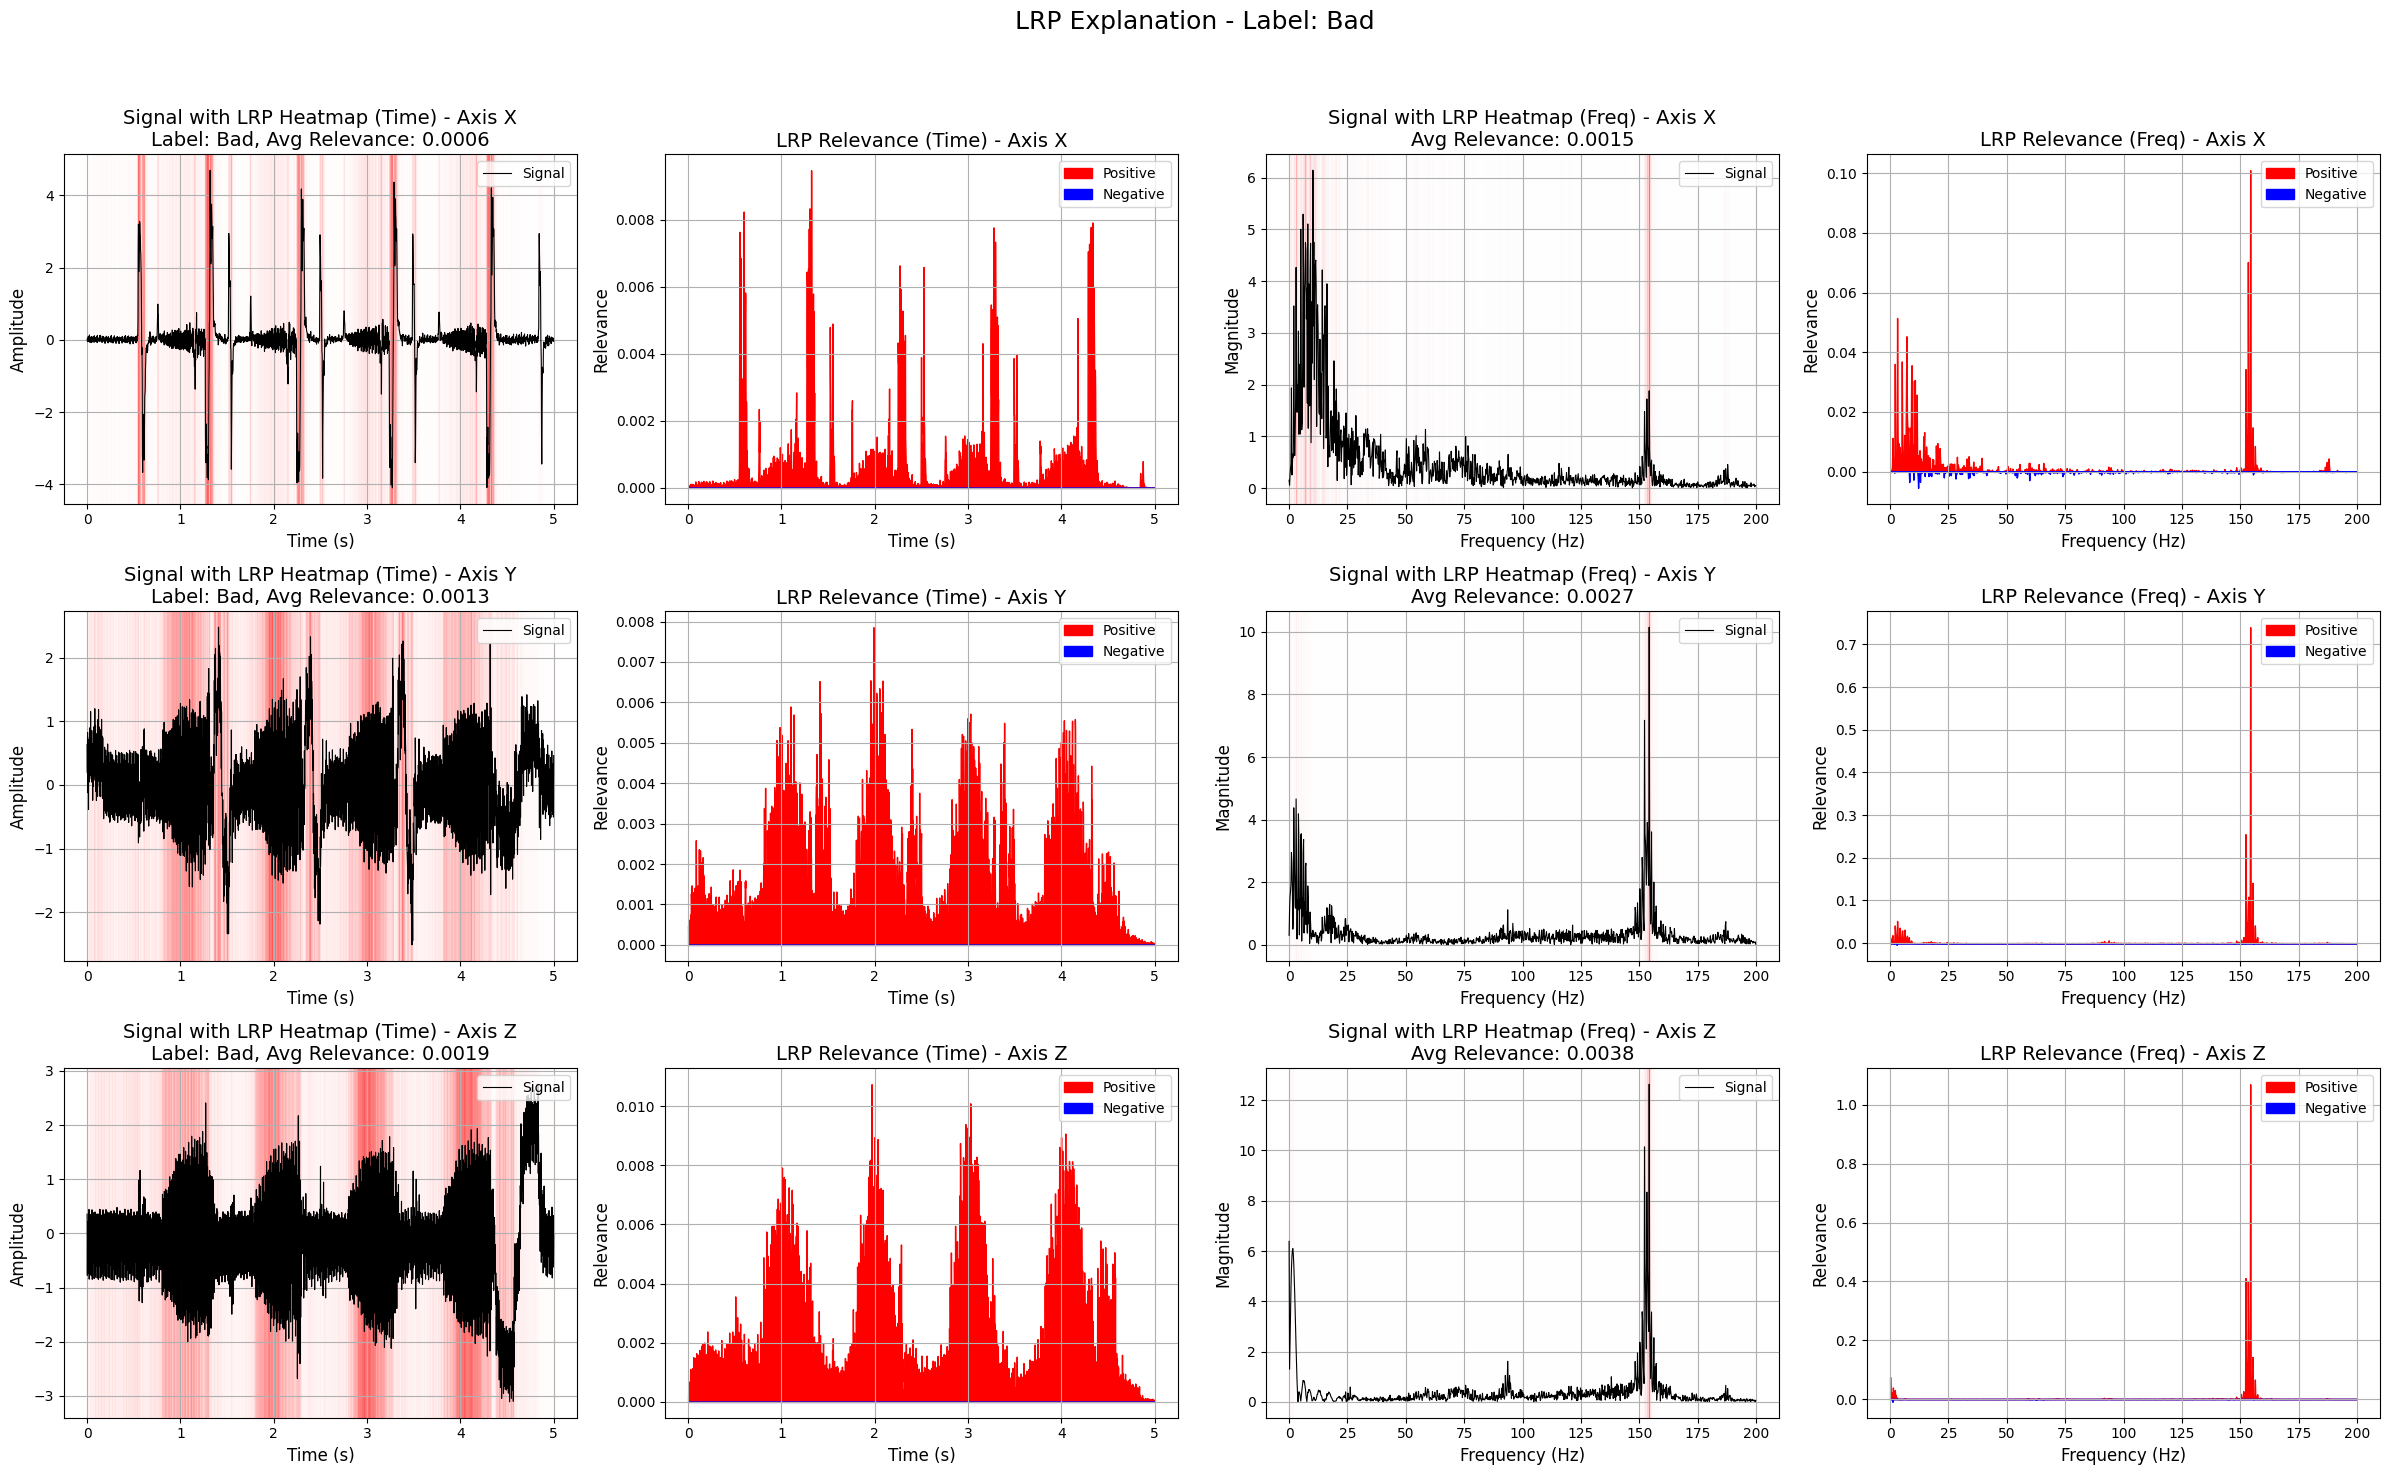

In [77]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [78]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             626                  1.365259   
1  Axis 1             721                  2.692618   
2  Axis 2             697                  3.774503   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002181             375                 -0.117953   
1                    0.003735             280                 -0.046292   
2                    0.005415             304                 -0.061547   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000315                     1.247306   
1                   -0.000165                     2.646326   
2                   -0.000202                     3.712956   

   Average Relevance (Pos + Neg)  
0                       0.001246  
1                       0.002644  
2                       0.003709  


In [79]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            2000                  1.247386   
1  Axis 1            2000                  2.646511   
2  Axis 2            2000                  3.711998   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000624               0                       0.0   
1                    0.001323               0                       0.0   
2                    0.001856               0                       0.0   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                           0                     1.247386   
1                           0                     2.646511   
2                           0                     3.711998   

   Average Relevance (Pos + Neg)  
0                       0.000624  
1                       0.001323  
2                       0.001856  
